In [1]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.82
    Uninstalling opencv-python-headless-4.10.0.82:
      Successfully uninstalled opencv-python-headless-4.10.0.82
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cyc

In [1]:
import os
import locale
import sys
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from typing import List
import matplotlib.pyplot as plt

from tqdm import tqdm
import cv2
import shutil

import re
import pandas as pd



In [ ]:
# Seteo y verifico configuración en_US.UTF-8
# Establecer la configuración regional en la sesión de Python
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'

# Obtener la configuración regional actual
current_locale = locale.getlocale()
print(f"Current locale: {current_locale}")

# Establecer una nueva configuración regional
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

In [2]:
#!os.system('nvidia-smi')
!nvidia-smi

Sun Jun 16 18:15:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="qoRuT4r6jXcLdFGD8Dc6")
project = rf.workspace("maestria").project("test03-pvwu2")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to Test03-2 in yolov8:: 100%|██████████| 2012/2012 [00:00<00:00, 6195.08it/s]


In [5]:
%cd {HOME}

!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ntmas5wp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ntmas5wp
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=e8f66728ffc982235360b31dcda34aa12c73f5d8edab78a8896d74ca5ed20690
  Stored in directory: /tmp/pip-ephem-wheel-cache-gkorvly0/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [6]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [7]:
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
SAM_ENCODER_VERSION = "vit_h"

In [10]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [11]:
# Proceso solo las imagenes de TRAIN, establezco directorio
directorio_imagenes = f"{HOME}/Test03-2/train/images"
CLASSES = ['ball']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

In [12]:
SOURCE_IMAGE_PATH = f"{HOME}/data/todo_pelota_mp4-0035_jpg.rf.7d3c3de9168b5d885136a27fe7921734.jpg"

In [13]:
def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

In [32]:
# Seteo directorios de MASK y BBOX para TRAIN
dataset_path = f"{HOME}/Test03-2/"
output_mask_path = f"{HOME}/Test03-2/train/masks"
os.makedirs(output_mask_path, exist_ok=True)

output_bbox_path = f"{HOME}/Test03-2/train/bbox"
os.makedirs(output_bbox_path, exist_ok=True)

def read_polygon_annotations(annotation_path, image_size):
    annotations = []
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            points = list(map(float, line.strip().split()))
            class_id = points[0]
            polygon = []
            for i in range(1, len(points), 2):
                x = points[i] * image_size[0]
                y = points[i + 1] * image_size[1]
                polygon.append((x, y))
            annotations.append(polygon)
    return annotations

def generate_masks(image_path, annotation_path, model):
    # Leer imagen
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Leer anotaciones de polígonos
    polygons = read_polygon_annotations(annotation_path, image.size)

    masks = []
    scores = []
    refined_masks = []
    for polygon in polygons:
        mask = np.zeros(image.size[::-1], dtype=np.uint8)  # Crear una máscara vacía
        # Convertir el polígono a una máscara
        polygon_np = np.array(polygon, dtype=np.int32)
        cv2.fillPoly(mask, [polygon_np],255)

        # Usar SAM para refinar la máscara
        sam_predictor.set_image(image_np)
        input_boxes = np.array([np.array(polygon).flatten()])
        input_boxes_torch = torch.from_numpy(input_boxes).float().to('cuda')   # Convertir a tensor de PyTorch
        transformed_boxes = sam_predictor.transform.apply_boxes_torch(input_boxes_torch, image.size)

        masks, _, _ = sam_predictor.predict_torch(
        #masks, scores_torch, _ = sam_predictor.predict_torch(  # si queremos utilizar la confianza/score
            point_coords=None,
            point_labels=None,
            boxes=transformed_boxes,
            multimask_output=False,
        )

        refined_mask = masks[0, 0].cpu().numpy()  # Extraer la máscara refinada por SAM
        #score = scores_torch[0].cpu().item()  # si queremos utilizar la confianza/score

        # Reemplazar la máscara original con la refinada por SAM
        mask = refined_mask * 255  # Convertir a escala 0-255
        refined_masks.append(mask)
        #scores.append(score)

    return refined_masks #, scores  # Si queremos cambiar la función para que devuelva los scores/confianza

def get_normalized_bounding_box(mask, image_size):
    try:
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            x, y, w, h = cv2.boundingRect(contours[0])
            x_center = (x + w / 2) / image_size[0]
            y_center = (y + h / 2) / image_size[1]
            width = w / image_size[0]
            height = h / image_size[1]
            return (0, x_center, y_center, width, height)
        else:
            return None
    except IndexError:
        return None



In [34]:
# Procesar cada imagen y etiqueta en el conjunto de datos
for split in ["train"]: #, "train","valid", "test"]:
    images_dir = os.path.join(dataset_path, split, "images")
    labels_dir = os.path.join(dataset_path, split, "labels")

    for image_file in tqdm(os.listdir(images_dir)):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(images_dir, image_file)
            annotation_file = image_file.replace(".jpg", ".txt")
            annotation_path = os.path.join(labels_dir, annotation_file)

            if os.path.exists(annotation_path):
                masks = generate_masks(image_path, annotation_path, sam_predictor)
                #masks, scores = generate_masks(image_path, annotation_path, sam_predictor) # si queremos obtener la confianza

                # Guardar las máscaras
                for i, mask in enumerate(masks):
                #for i, (mask, score) in enumerate(zip(masks, scores)):
                    mask_image = Image.fromarray(mask.astype(np.uint8))  # Convierte la máscara a una imagen
                    mask_image.save(os.path.join(output_mask_path, f"{os.path.splitext(image_file)[0]}_mask_{i}.png"))

                    # Obtener el tamaño de la imagen para calcular el bounding box en coordenadas normalizadas
                    image = Image.open(image_path)
                    image_size = image.size

                    # Generar y guardar el bounding box de la máscara en coordenadas normalizadas junto con el score
                    bbox_normalized = get_normalized_bounding_box(mask, image_size)
                    if bbox_normalized is not None:
                        bbox_file_path = os.path.join(output_bbox_path, f"{os.path.splitext(image_file)[0]}_bbox_{i}.txt")
                        with open(bbox_file_path, 'w') as bbox_file:
                            bbox_file.write(f"0 {bbox_normalized[1]} {bbox_normalized[2]} {bbox_normalized[3]} {bbox_normalized[4]}\n") # {score}


100%|██████████| 700/700 [15:42<00:00,  1.35s/it]


**Código para validar mascaras y bounding box generados con el proceso anterior. Es opcional su ejecución.**

Mask not found for intermedia_720-Hecho-con-Clipchamp_mp4-0005_jpg.rf.c6cbdf230680d7f0f60ebc9f74318a6c.jpg


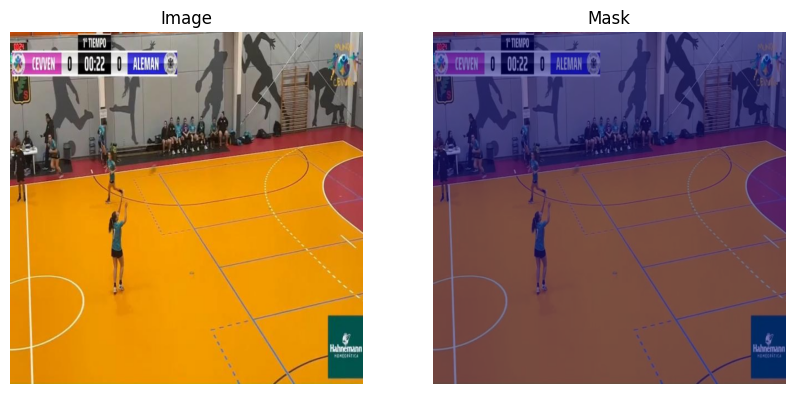

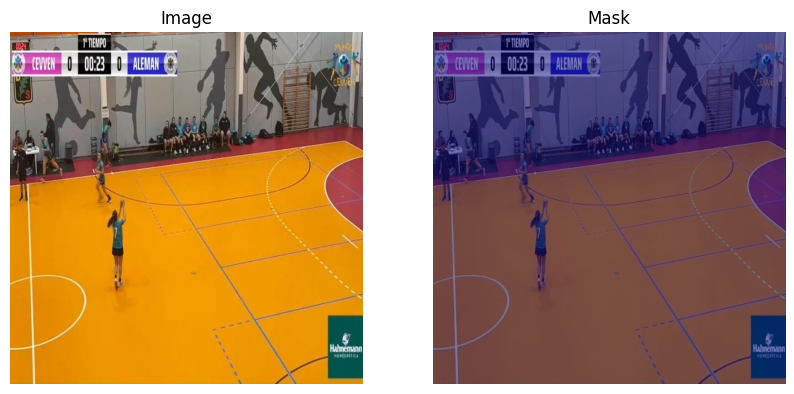

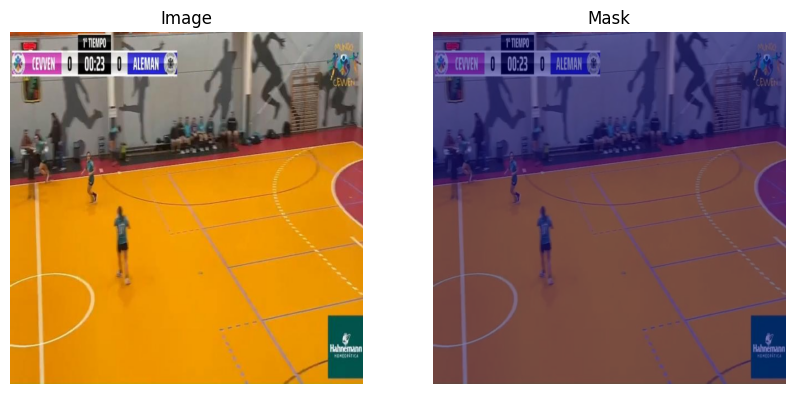

Mask not found for intermedia_720-Hecho-con-Clipchamp_mp4-0033_jpg.rf.88f38350eeb1be05fccaca36f536315b.jpg


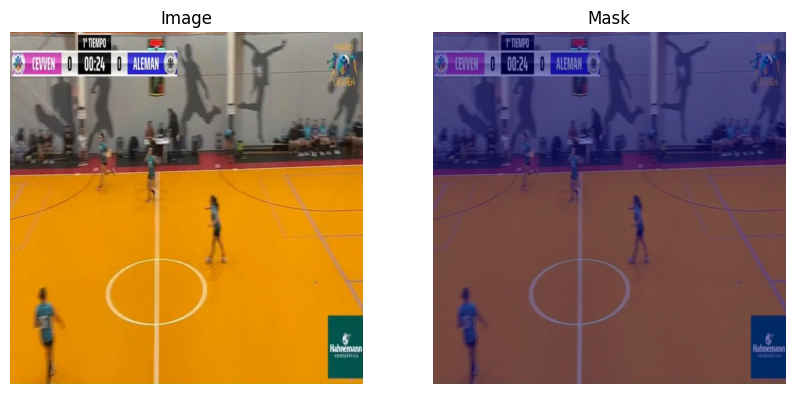

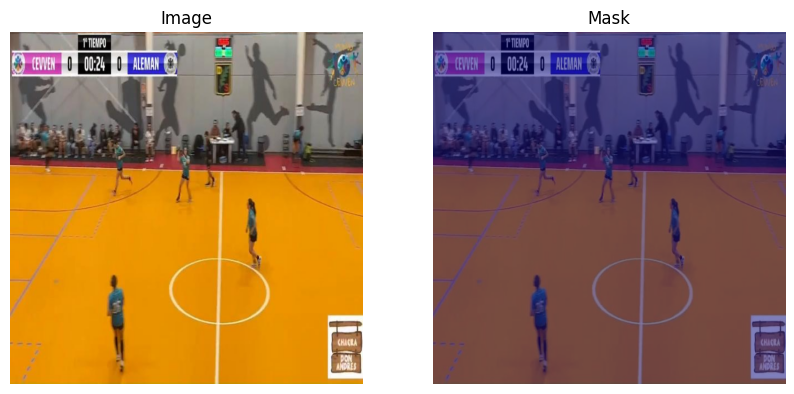

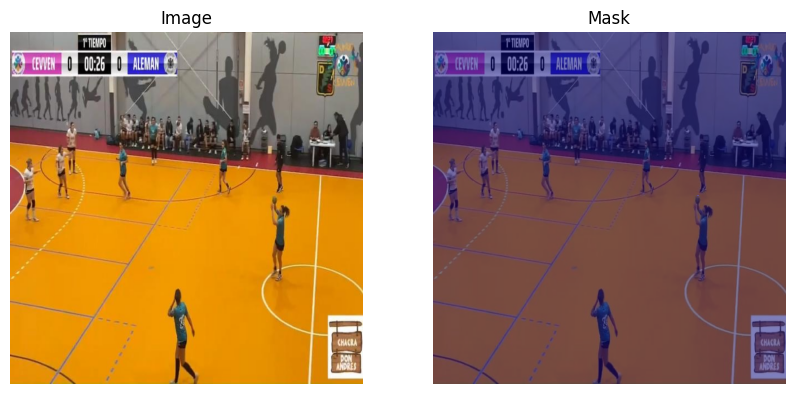

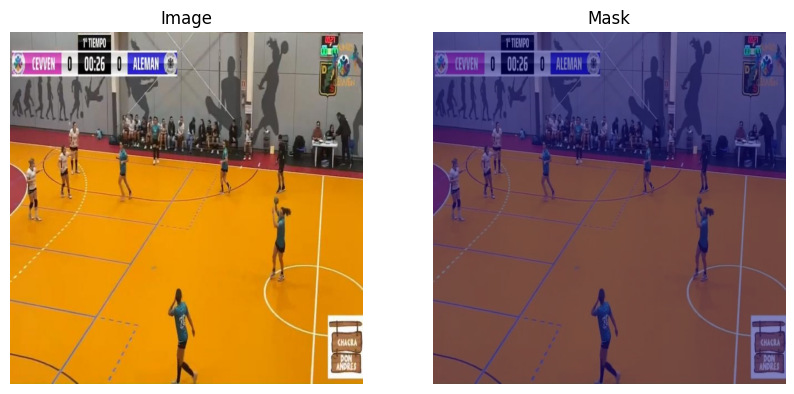

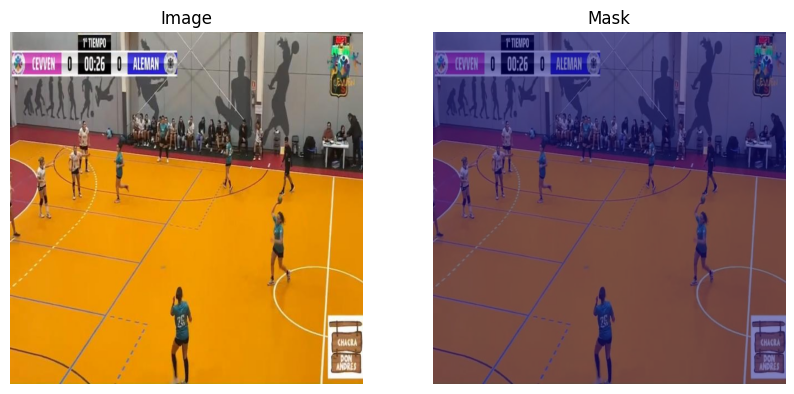

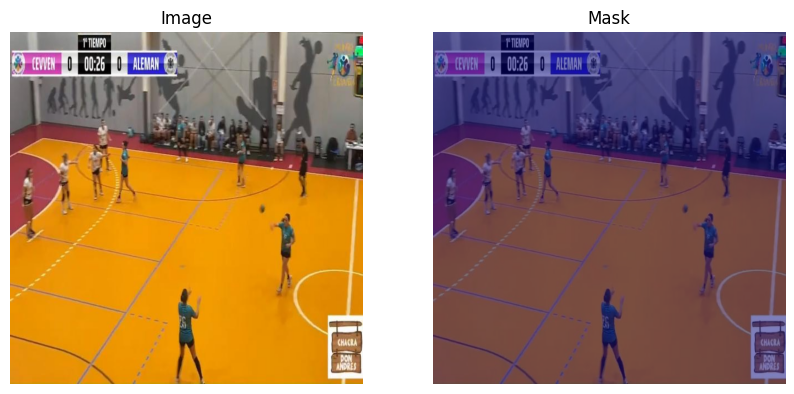

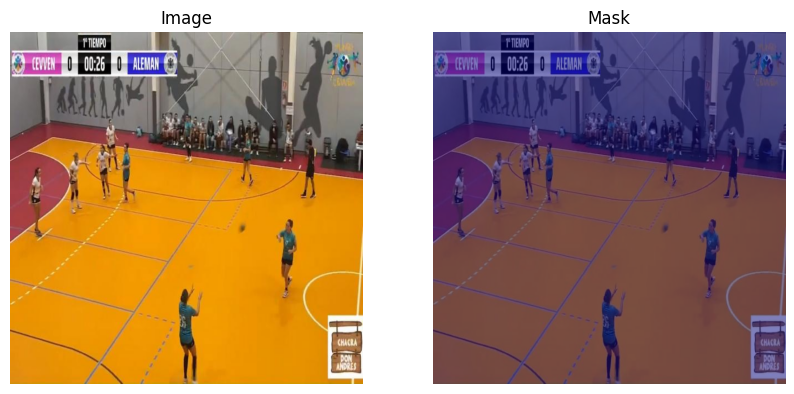

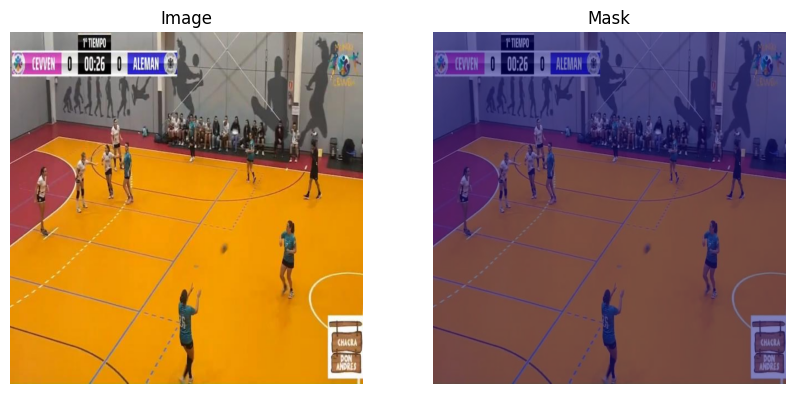

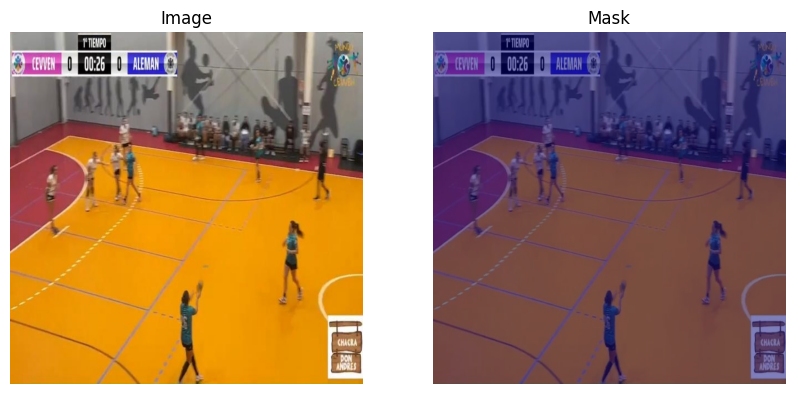

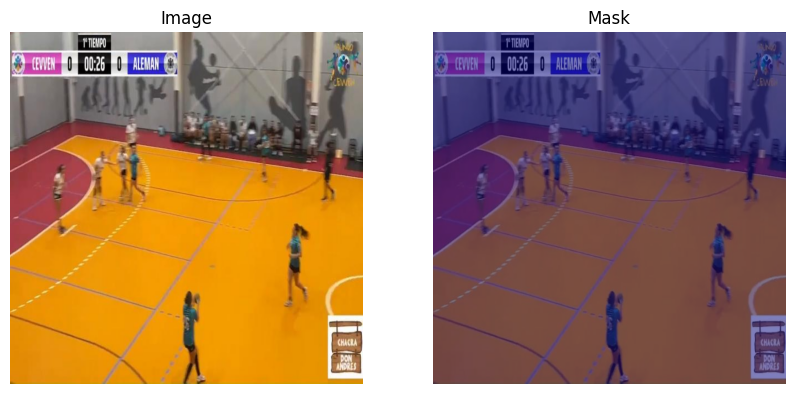

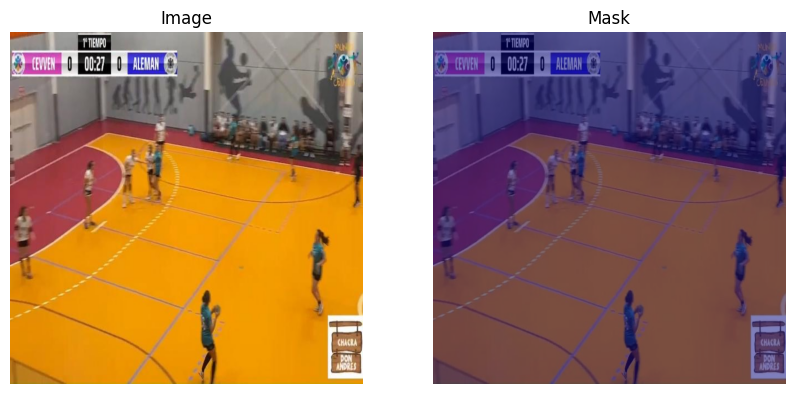

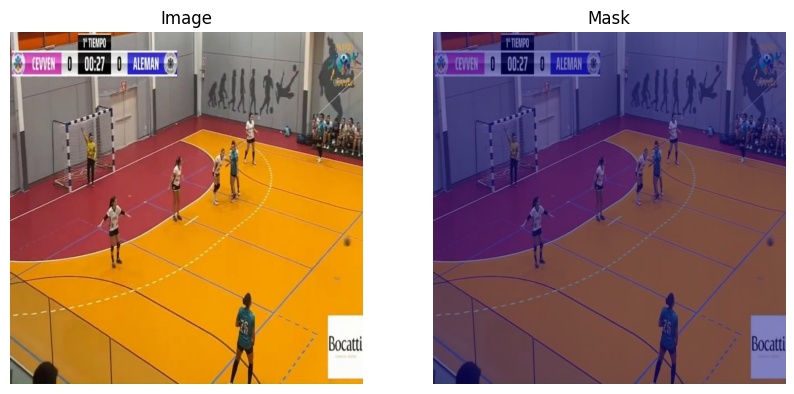

Mask not found for intermedia_720-Hecho-con-Clipchamp_mp4-0180_jpg.rf.e03059e63528c118732f9c158a0820ca.jpg
Mask not found for intermedia_720-Hecho-con-Clipchamp_mp4-0208_jpg.rf.cb57e3a50a460d25962747af6599577b.jpg
Mask not found for intermedia_720-Hecho-con-Clipchamp_mp4-0210_jpg.rf.543ed8e57523d2085e66f19dbd29ade2.jpg


In [ ]:
# Este código solo lo utilizamos a modo de validación

# Directorios
dataset_path = f"{HOME}/Test03-2/"
images_dir = os.path.join(dataset_path, "train", "images")
masks_dir = os.path.join(dataset_path, "train", "masks")
bbox_dir = os.path.join(dataset_path, "train", "masks")

# Obtener una lista de las imágenes
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".jpg")])[:20]

# Función para visualizar una imagen y su máscara
def visualize_image_and_mask(image_path, mask_path):
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title("Image")
    ax[0].axis("off")

    ax[1].imshow(image)
    ax[1].imshow(mask, alpha=0.5, cmap="jet")  # Superponer la máscara en la imagen
    ax[1].set_title("Mask")
    ax[1].axis("off")

    plt.show()

# Visualizar las primeras 20 imágenes y sus máscaras
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    mask_path = os.path.join(masks_dir, f"{os.path.splitext(image_file)[0]}_mask_0.png")

    if os.path.exists(mask_path):
        visualize_image_and_mask(image_path, mask_path)
    else:
        print(f"Mask not found for {image_file}")


 Zipeamos y descargamos archivos generados a disco.

In [36]:
# Ruta de la carpeta a MASKS
ruta_carpeta = '/content/Test03-2/train/masks'

# Ruta de salida del archivo zip
ruta_zip = '/content/Test03-2/train/train_masks.zip'

# Comprimir la carpeta
shutil.make_archive(ruta_zip.replace('.zip', ''), 'zip', ruta_carpeta)

# Ruta de la carpeta a BBOX
ruta_carpeta = '/content/Test03-2/train/bbox'

# Ruta de salida del archivo zip
ruta_zip = '/content/Test03-2/train/train_bbox.zip'

# Comprimir la carpeta
shutil.make_archive(ruta_zip.replace('.zip', ''), 'zip', ruta_carpeta)

'/content/Test03-2/train/train_bbox.zip'

In [37]:
from google.colab import files

# Descargar el archivo
files.download(ruta_zip)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Comparar bounding box original y bounding box de la máscara predicha por SAM**

In [87]:
import sys
import pandas as pd
sys.path.append('/content')
from zfunctions_annotations import get_annotations_from_file, compare_annotations_predictions, get_bbox_from_yolo_annotation

no_tiene=0

label_folder_1 = '/content/Test03-2/train/labels/'

label_folder_2 = '/content/Test03-2/train/bbox/'

labels1 = sorted([os.path.join(label_folder_1, f) for f in os.listdir(label_folder_1) if f.lower().endswith(('.txt'))])
labels1 = {re.sub("(.*)\.[a-z0-9]{32}\.txt","\\1.txt", f):f for f in labels1}

labels2 = sorted([os.path.join(label_folder_2, f) for f in os.listdir(label_folder_2) if f.lower().endswith(('.txt'))])
labels2 = {re.sub("(.*)\.[a-z0-9]{32}_bbox_0\.txt","\\1.txt", f):f for f in labels2}

annotations_and_detections = pd.DataFrame(columns=['File1','File2','AClass','Ax1','Ay1','Ax2','Ay2','PClass','Px1','Py1','Px2','Py2','PConf','Union','Intersection','IoU','Result'])
a_a_d_index = 0


for l1 in iter(labels1):
    annotation1 =  get_annotations_from_file(labels1[l1], height=640, width=640)
    l2_key = re.sub("(.*)\.[a-z0-9]{32}\.txt","\\1.txt", l1.replace(label_folder_1,label_folder_2))

    if l2_key in labels2:
        if os.path.isfile(labels2[l2_key]):
            annotation2 = get_annotations_from_file(labels2[l2_key], height=640, width=640)

            if len(annotation1)>0 and len(annotation2)>0:
                comparisons = compare_annotations_predictions(annotation1,annotation2,0.3)
                # la comparación devuelve una lista de resultados (en nuestro caso se espera solo uno):
                # [
                #  ...
                # [clase_en_anotacion,[anotacion_x1,anotacion_y1,anotacion_x2,anotacion_y2],clase_en_prediccion,[prediccion_x1,prediccion_y1,prediccion_x2,prediccion_y2, confifdencia (nan en nuestro caso)], union, interseccion, iou, valoracion]
                # ...
                #]
                # valoración puede ser TP, FP, FN (no TN porque sería que no está en las anotaciones ni en las predicciones)
                for comparison in comparisons:
                    class_id = comparison[0] or comparison[2]
                    annotation = comparison[1]
                    prediction = comparison[3]
                    union = comparison[4]
                    interection = comparison[5]
                    iou = comparison[6]
                    result = comparison[7]
                    aclass, ax1, ay1, ax2, ay2, pclass, px1, py1, px2, py2, pconf = np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN
                    if len(annotation)==5:
                        aclass, ax1, ay1, ax2, ay2 = annotation
                    if len(prediction)==6: ## 6
                        pclass, px1, py1, px2, py2, pconf = prediction

                    nueva_fila={'File1':labels1[l1], 'File2':labels2[l2_key], 'AClass':comparison[0], 'Ax1':ax1, 'Ay1':ay1, 'Ax2':ax2, 'Ay2':ay2, 'PClass':pclass, 'Px1':px1, 'Py1':py1, 'Px2':px2, 'Py2':py2,
                                'PConf':pconf, 'Union':union, 'Intersection': interection, 'IoU':iou, 'Result':result}
                    annotations_and_detections = pd.concat([annotations_and_detections, pd.DataFrame(nueva_fila, index = [a_a_d_index])])
                    a_a_d_index += 1
    else:
         if len(annotation1)>0:
            if len(annotation1[0])==5:
                aclass, ax1, ay1, ax2, ay2 = get_bbox_from_yolo_annotation(annotation1[0])

                nueva_fila={'File1':labels1[l1], 'File2':'', 'AClass':aclass, 'Ax1':ax1, 'Ay1':ay1, 'Ax2':ax2, 'Ay2':ay2, 'PClass':np.NaN, 'Px1':np.NaN, 'Py1':np.NaN, 'Px2':np.NaN, 'Py2':np.NaN,
                                  'PConf':np.NaN, 'Union':(ax2-ax1)*(ay2-ay1), 'Intersection': 0, 'IoU':0, 'Result':'FN'}
                annotations_and_detections = pd.concat([annotations_and_detections, pd.DataFrame(nueva_fila, index = [a_a_d_index])])
                a_a_d_index += 1
         else:
               no_tiene+=1

#print(no_tiene)


In [88]:
annotations_and_detections.Result.value_counts()

Result
FN    344
TP     71
FP     29
Name: count, dtype: int64